## Cálculo de tarifa de seguro provisional para invalidez y sobreviviencia 2024

Consideramos la tarifa a calcular como:

$$\text{Tarifa} = \frac{\text{Costo Esperado de siniestros (2024)}}{\text{Masa salarial esperada (2024)}}$$

Donde:

$$\text{Costo}=\text{Frecuecia}(q_x)\quad \cdot \quad \text{severidad}(S_x)$$

### Análisis de Frecuencia:

Uso FechaSiniestro para agrupar por año. Se cruzan con expuestos para calcular tasa

In [40]:
#Librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [41]:
#Cargar datos
df_siniestros = pd.read_excel("data/Data.xlsx", sheet_name='Historico de siniestros')
df_expuestos = pd.read_excel("data/Data.xlsx", sheet_name='Afiliados expuestos')


In [42]:
df_siniestros['FechaSiniestro'] = pd.to_datetime(df_siniestros['FechaSiniestro'])
df_siniestros['FechaPago'] = pd.to_datetime(df_siniestros['FechaPago'])

In [43]:
df_siniestros['AñoOcurrencia'] = df_siniestros['FechaSiniestro'].dt.year

df_siniestros_filtro = df_siniestros[
    (df_siniestros['AñoOcurrencia'] >= 2018) & 
    (df_siniestros['AñoOcurrencia'] <= 2023)].copy()


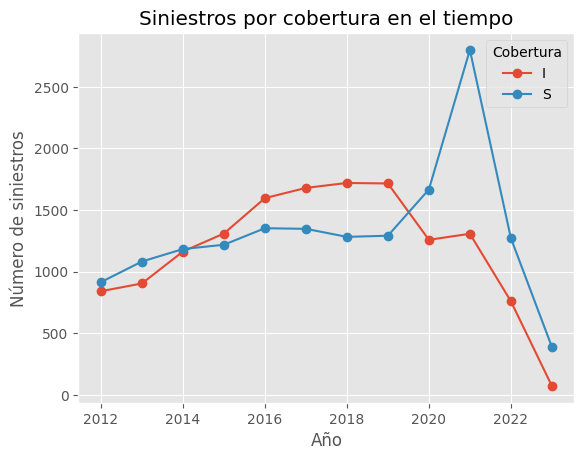

In [44]:
#Sin filtrar
conteo_siniestros_total = df_siniestros.groupby(['AñoOcurrencia', 'Cobertura']).size().reset_index(name='NumSiniestros')
df_pivot = conteo_siniestros_total.pivot(index="AñoOcurrencia", columns="Cobertura", values="NumSiniestros")

plt.style.use('ggplot')
ax = df_pivot.plot(marker='o')
ax.set_xlabel("Año")
ax.set_ylabel("Número de siniestros")
ax.set_title("Siniestros por cobertura en el tiempo")
ax.legend(title="Cobertura")
plt.grid(True)
plt.show()

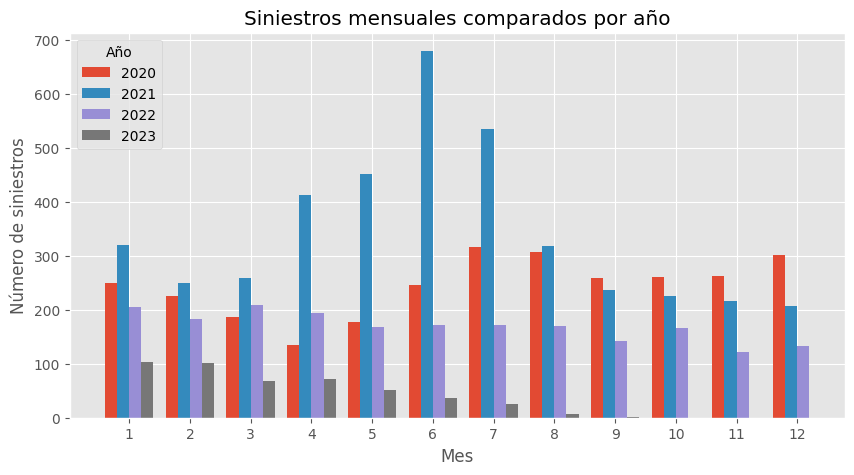

In [45]:
df_siniestros['Mes'] = df_siniestros['FechaSiniestro'].dt.month
conteo_siniestros_mes= df_siniestros.groupby(['Mes', 'AñoOcurrencia']).size().reset_index(name='NumSiniestros')
df_pivot3 = conteo_siniestros_mes.pivot(index="Mes", columns="AñoOcurrencia", values="NumSiniestros")

df_pivot3 = df_pivot3[ [2020, 2021, 2022, 2023]]

meses = df_pivot3.index
anios = df_pivot3.columns
x = np.arange(len(meses))   # posiciones base
width = 0.8 / len(anios)    # ancho de cada barra

fig, ax = plt.subplots(figsize=(10,5))

for i, anio in enumerate(anios):
    ax.bar(
        x + i*width,
        df_pivot3[anio],
        width=width,
        label=str(anio)
    )

# Ejes
ax.set_xticks(x + width*(len(anios)-1)/2)
ax.set_xticklabels(meses)
ax.set_xlabel("Mes")
ax.set_ylabel("Número de siniestros")
ax.set_title("Siniestros mensuales comparados por año")
ax.legend(title="Año", frameon=True)

### Análisis de tiempo de pago

Todas los siniestros de 2023, se han pagado, 

Es decir que la base no contepla siniestros ocurridos en proceso

No podemos distinguir entre siniestros No Reportados (IBNR puro) y los que están En Trámite (RBNS).

Consecuencias:

Calcularemos una Reserva Total (IBNR + RBNS) basada únicamente en la velocidad histórica de pagos.

Riesgo: Si en 2023 hubo un aumento de reportes que aún no se pagan (cuello de botella administrativo), el modelo de pagos no lo "verá" y podríamos subestimar el costo final de ese año.


                 mean    50%     max
Cobertura                           
I          561.847555  467.0  4252.0
S          357.079390  214.0  4024.0
casos largos
Cobertura
I    66.008512
S    26.961032
Name: Lag_Dias, dtype: float64
Proceso juridico
No    98.354565
Si     1.645435
Name: proportion, dtype: float64
4.555943437914273


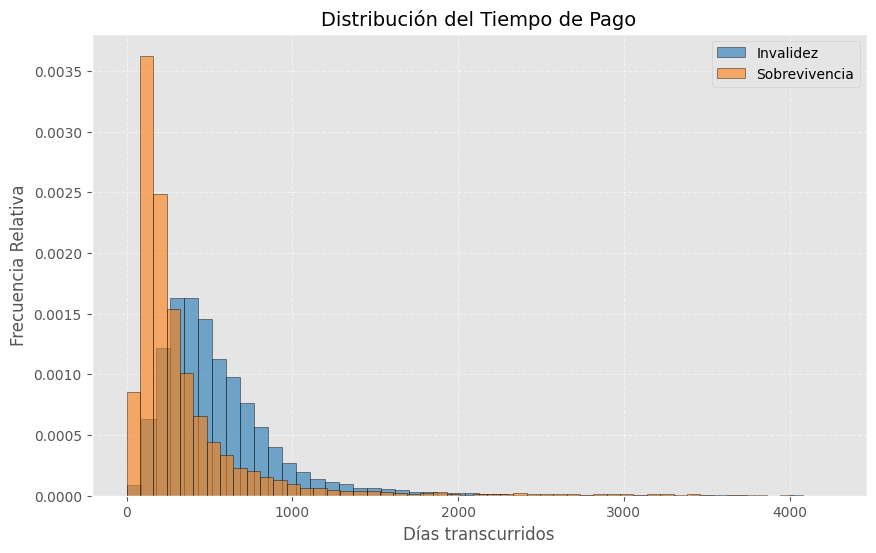

In [46]:
df_siniestros['FechaSiniestro'] = pd.to_datetime(df_siniestros['FechaSiniestro'])
df_siniestros['FechaPago'] = pd.to_datetime(df_siniestros['FechaPago'])

df_siniestros['Lag_Dias'] = (df_siniestros['FechaPago'] - df_siniestros['FechaSiniestro']).dt.days
df_siniestros['AñoPago'] =df_siniestros['FechaPago'].dt.year
# eliminamos fechas negativas si existen
df_lag = df_siniestros[df_siniestros['Lag_Dias'] >= 0].copy()

#Estadísticas del Retraso
#promedio, mediana y máximo para Invalidez (I) y Sobrevivencia (S)
stats_lag = df_lag.groupby('Cobertura')['Lag_Dias'].describe()

# porcentaje tarda más de 1 año
def pct_mayor_1_anio(x):
    return (x > 365).mean() * 100

retraso_largo = df_lag.groupby('Cobertura')['Lag_Dias'].apply(pct_mayor_1_anio)

# % con proceso juridico
porc_pj = (df_siniestros['Proceso juridico'].value_counts(normalize=True) * 100)
promedio_años_procjur = (
    (df_siniestros
    .loc[df_siniestros['Proceso juridico'] == 'Si', 'Lag_Dias']
    .mean())/365
)


print(stats_lag[['mean', '50%', 'max']])
print('casos largos')
print(retraso_largo)

print(porc_pj )
print(promedio_años_procjur)


# 4. Generación de la Gráfica (Histograma)
plt.figure(figsize=(10, 6))

# Histograma para Invalidez
df_lag[df_lag['Cobertura'] == 'I']['Lag_Dias'].hist(
    bins=50, 
    alpha=0.6, 
    label='Invalidez', 
    density=True, 
    color='#1f77b4', 
    edgecolor='black'
)

# Histograma para Sobrevivencia
df_lag[df_lag['Cobertura'] == 'S']['Lag_Dias'].hist(
    bins=50, 
    alpha=0.6, 
    label='Sobrevivencia', 
    color='#ff7f0e', 
    density=True, 
    edgecolor='black'
)

plt.title("Distribución del Tiempo de Pago", fontsize=14)
plt.xlabel("Días transcurridos", fontsize=12)
plt.ylabel("Frecuencia Relativa", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [47]:
# % Procesos jurídicos por año

tabla_porc = (
    df_siniestros
    .groupby('AñoOcurrencia')['Proceso juridico']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Porcentaje')
    .reset_index()
)


tabla_porc[tabla_porc['Proceso juridico']=='Si']


,AñoOcurrencia,Proceso juridico,Porcentaje
1,2012,Si,4.721274
3,2013,Si,5.130785
5,2014,Si,3.790460
7,2015,Si,2.926058
9,2016,Si,1.423729
11,2017,Si,0.924703
13,2018,Si,1.032301
15,2019,Si,0.465426
17,2020,Si,0.341763
19,2021,Si,0.389579


In [48]:
df_expuestos['Tasa_Crecimiento'] = df_expuestos['Expuestos'].pct_change()

print(df_expuestos)

    Año     Expuestos  Tasa_Crecimiento
0  2018  2.236297e+06               NaN
1  2019  2.257517e+06          0.009489
2  2020  2.253114e+06         -0.001950
3  2021  2.273738e+06          0.009154
4  2022  2.412411e+06          0.060989
5  2023  2.403624e+06         -0.003642
6  2024  2.403624e+06          0.000000


In [49]:
#Asumimos I = Invalidez, S = sobrevivencia
# Filtrado (2018-2023)
conteo_siniestros = df_siniestros_filtro.groupby(['AñoOcurrencia', 'Cobertura']).size().reset_index(name='NumSiniestros')
print(conteo_siniestros)

    AñoOcurrencia Cobertura  NumSiniestros
0            2018         I           1720
1            2018         S           1283
2            2019         I           1716
3            2019         S           1292
4            2020         I           1259
5            2020         S           1667
6            2021         I           1308
7            2021         S           2799
8            2022         I            761
9            2022         S           1273
10           2023         I             74
11           2023         S            391


In [50]:
df_tasas = pd.merge(conteo_siniestros, df_expuestos, left_on='AñoOcurrencia', right_on='Año', how='left')


df_tasas['Tasa_Incidencia'] = df_tasas['NumSiniestros'] / df_tasas['Expuestos']
tasa_invalidez = df_tasas[df_tasas['Cobertura'] == 'I'].set_index('Año')
tasa_sobrevivencia = df_tasas[df_tasas['Cobertura'] == 'S'].set_index('Año')

print(tasa_invalidez[['NumSiniestros', 'Expuestos', 'Tasa_Incidencia']])
print(tasa_sobrevivencia[['NumSiniestros', 'Expuestos', 'Tasa_Incidencia']])

      NumSiniestros     Expuestos  Tasa_Incidencia
Año                                               
2018           1720  2.236297e+06         0.000769
2019           1716  2.257517e+06         0.000760
2020           1259  2.253114e+06         0.000559
2021           1308  2.273738e+06         0.000575
2022            761  2.412411e+06         0.000315
2023             74  2.403624e+06         0.000031
      NumSiniestros     Expuestos  Tasa_Incidencia
Año                                               
2018           1283  2.236297e+06         0.000574
2019           1292  2.257517e+06         0.000572
2020           1667  2.253114e+06         0.000740
2021           2799  2.273738e+06         0.001231
2022           1273  2.412411e+06         0.000528
2023            391  2.403624e+06         0.000163


### Proyección de parámetros 2024

Hay datos atípicos en 2020,2021 por covid 
2022, porque puede ser que todavía hay casos que no se han reportado
2023, porque hay datos hasta 09 y también puede haber casos que no se han reportado


#### Intento RL

In [49]:

X_train = df_expuestos['Año'].values.reshape(-1, 1)
y_train = df_expuestos['Expuestos'].values

modelo_exp = LinearRegression()
modelo_exp.fit(X_train, y_train)

# Generamos los años faltantes (2012-2017)
anos_faltantes = np.arange(2012, 2018).reshape(-1, 1)
expuestos_estimados = modelo_exp.predict(anos_faltantes)

# Creamos el dataframe completado
df_expuestos_historico = pd.DataFrame({
    'Año': anos_faltantes.flatten(),
    'Expuestos': expuestos_estimados
})
# Unimos con los datos reales
df_expuestos_full = pd.concat([df_expuestos_historico, df_expuestos]).sort_values('Año').reset_index(drop=True)
df_expuestos_full

,Año,Expuestos,Tasa_Crecimiento
0,2012,2.013567e+06,NaN
1,2013,2.047620e+06,NaN
2,2014,2.081673e+06,NaN
3,2015,2.115727e+06,NaN
4,2016,2.149780e+06,NaN
5,2017,2.183833e+06,NaN
6,2018,2.236297e+06,NaN
7,2019,2.257517e+06,0.009489
8,2020,2.253114e+06,-0.001950
9,2021,2.273738e+06,0.009154


In [ ]:
df_tasas_limpio = pd.merge(conteo_limpio, df_expuestos_full, left_on='AñoOcurrencia', right_on='Año', how='inner')

df_tasas_limpio['Tasa_limpio'] = df_tasas_limpio['NumSiniestros_limpio'] / df_tasas_limpio['Expuestos']


inv_data = df_tasas_limpio[df_tasas_limpio['Cobertura'] == 'I']
sob_data = df_tasas_limpio[df_tasas_limpio['Cobertura'] == 'S']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(inv_data['Año'], inv_data['Tasa_limpio'], marker='o', label='Invalidez (Sin Covid)')
plt.title('Tendencia Estructural Invalidez (2012-2023)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sob_data['Año'], sob_data['Tasa_limpio'], marker='o', color='orange', label='Sobrevivencia (Sin Covid)')
plt.title('Tendencia Estructural Sobrevivencia (2012-2023)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### Ajuste por covid

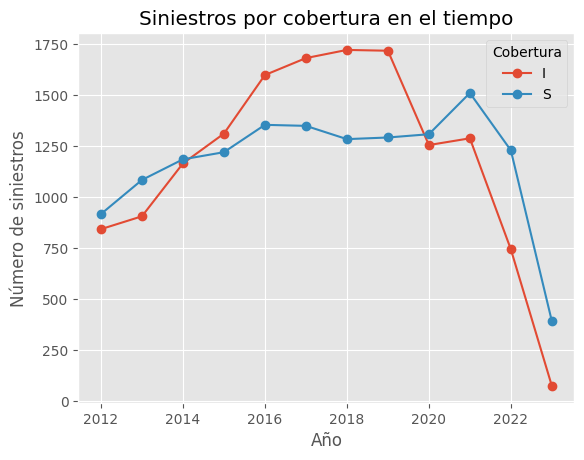

In [51]:
df_limpio_siniestros = df_siniestros[df_siniestros['Covid'] != 'Si'].copy()

conteo_limpio = df_limpio_siniestros.groupby(['AñoOcurrencia', 'Cobertura']).size().reset_index(name='NumSiniestros_limpio')

df_pivot2 = conteo_limpio.pivot(index="AñoOcurrencia", columns="Cobertura", values="NumSiniestros_limpio")

plt.style.use('ggplot')
ax = df_pivot2.plot(marker='o')
ax.set_xlabel("Año")
ax.set_ylabel("Número de siniestros")
ax.set_title("Siniestros por cobertura en el tiempo")
ax.legend(title="Cobertura")
plt.grid(True)
plt.show()

In [52]:
a= df_siniestros[(df_siniestros['Covid']=='Si') & (df_siniestros['AñoOcurrencia']== 2021)].groupby('Cobertura').size()
b =df_siniestros[(df_siniestros['Covid']=='Si') & (df_siniestros['AñoOcurrencia']== 2021)].groupby('Cobertura').size()/df_siniestros[df_siniestros['AñoOcurrencia']== 2021].groupby('Cobertura').size()

c= df_siniestros[(df_siniestros['Covid']=='Si') & (df_siniestros['AñoOcurrencia']== 2020)].groupby('Cobertura').size()
d =df_siniestros[(df_siniestros['Covid']=='Si') & (df_siniestros['AñoOcurrencia']== 2020)].groupby('Cobertura').size()/df_siniestros[df_siniestros['AñoOcurrencia']== 2020].groupby('Cobertura').size()



print('2020')
print(c)
print(d)


print('2021')
print(a)
print(b)

2020
Cobertura
I      5
S    360
dtype: int64
Cobertura
I    0.003971
S    0.215957
dtype: float64
2021
Cobertura
I      21
S    1290
dtype: int64
Cobertura
I    0.016055
S    0.460879
dtype: float64


#### Ajuste IBNR 2022 y 2023

Triángulo de desarrollo Teoría:

El método Chain Ladder se basa en la suposición de que el patrón de retraso en los pagos es estable en el tiempo.A. El Factor de Enlace (Link Ratio) - $f_{j}$Representa la "velocidad de crecimiento" acumulada de un periodo a otro.Fórmula:$$f_{j} = \frac{\sum \text{Siniestros Acumulados en Lag } (j+1)}{\sum \text{Siniestros Acumulados en Lag } j}$$Interpretación: Si $f_{0} = 1.5$, significa que históricamente, por cada 100 siniestros que pagaste el primer año (Lag 0), terminas pagando 150 al cierre del segundo año (Lag 1). Creciste un 50%.B. El Factor de Desarrollo Acumulado (CDF) - $F_{j}$Es el multiplicador que lleva lo que se ve hoy hasta el valor final (Ultimate). Se construye multiplicando todos los Link Ratios futuros.Fórmula:$$CDF_{j} = f_{j} \times f_{j+1} \times f_{j+2} \times \dots \times f_{\text{final}}$$Tu Caso Real (Invalidez Lag 0):Obtuvimos un $CDF_0 \approx 10.28$.Esto sale de multiplicar: (Crece de año 0 a 1) $\times$ (Crece de 1 a 2) $\times$ ...Significado: "Lo que vemos pagado hoy en el primer año es solo la décima parte ($1/10.28$) de lo que realmente ocurrió".C. Fórmula de Proyección Final (Ultimate)Para "llenar" los años incompletos (2022 y 2023), aplicamos:$$N_{\text{Ultimate}} = N_{\text{Reportado Actual}} \times CDF_{\text{Lag Actual}}$$Donde:$N_{\text{Reportado Actual}}$:$CDF_{\text{Lag Actual}}$. Fórmula del IBNR (Reserva)Es la diferencia entre lo que estimamos que costará al final y lo que ya pagamos.$$IBNR = N_{\text{Ultimate}} - N_{\text{Reportado Actual}}$$

In [72]:
df_siniestros['FechaSiniestro'] = pd.to_datetime(df_siniestros['FechaSiniestro'])
df_siniestros['FechaPago'] = pd.to_datetime(df_siniestros['FechaPago'])

# Filtro Exclusión COVID
df_limpio = df_siniestros[df_siniestros['Covid'] == 'No'].copy()
df_limpio['AnoSiniestro'] = df_limpio['FechaSiniestro'].dt.year
df_limpio['AnoPago'] = df_limpio['FechaPago'].dt.year
df_limpio['Lag'] = df_limpio['AnoPago'] - df_limpio['AnoSiniestro']

# Filtrar rango - 11 años (hasta 2023)
df_base = df_limpio[(df_limpio['AnoSiniestro'] >= 2012) & (df_limpio['AnoSiniestro'] <= 2023)]

# --- 2. Función Chain Ladder ---
def calcular_ultimate(df, cobertura):
    # Crear Triángulo Incremental
    df_sub = df[df['Cobertura'] == cobertura]
    tri_I = df_sub.pivot_table(index='AnoSiniestro', columns='Lag', values='Clave', aggfunc='count', fill_value=0)
    
    # Triángulo Acumulado
    tri_Cum = tri_I.cumsum(axis=1)
    
    # Calcular Factores (Link Ratios)
    link_ratios = []
    for j in range(tri_Cum.shape[1] - 1):
        # Usar solo años con historia completa para el paso j -> j+1
        idx = tri_Cum.index[tri_Cum.index <= (2023 - (j + 1))]
        #todos los casos en el año sigiente / año actual
        ratio = tri_Cum.loc[idx, j+1].sum() / tri_Cum.loc[idx, j].sum()
        link_ratios.append(ratio)
        
    # Calcular CDF 
    cdfs = [1.0] * tri_Cum.shape[1]
    temp = 1.0
    for i in range(len(link_ratios)-1, -1, -1):
        temp *= link_ratios[i]
        cdfs[i] = temp
        
    return tri_Cum, cdfs

# Calcular para ambas coberturas
tri_Cum_inv, cdfs_inv = calcular_ultimate(df_base, 'I')
tri_Cum_sob, cdfs_sob = calcular_ultimate(df_base, 'S')

# --- 3. Aplicar Factores a 2022 y 2023 ---
resultados = []
for ano in [ 2018,2019, 2020,2021,2022, 2023]:
    lag = 2023 - ano
    
    # Invalidez
    actual_inv = tri_Cum_inv.loc[ano].iloc[lag]
    ult_inv = actual_inv * cdfs_inv[lag]
    
    # Sobrevivencia
    actual_sob = tri_Cum_sob.loc[ano].iloc[lag]
    ult_sob = actual_sob * cdfs_sob[lag]
    
    resultados.append({'Año': ano, 'Inv_Ult': ult_inv, 'Sob_Ult': ult_sob})

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

    Año      Inv_Ult      Sob_Ult
0  2018  1802.257016  1390.481228
1  2019  1833.158836  1419.365286
2  2020  1389.114775  1472.939792
3  2021  1569.964060  1778.926444
4  2022  1378.103313  1648.967325
5  2023   760.897341  1223.126295


In [73]:
#Reemplazos nuevos valores

#Invalidez
nuevo_I2018 = df_resultados.loc[
    df_resultados['Año'] == 2018, 
    'Inv_Ult'
].values[0]
nuevo_I2019 = df_resultados.loc[
    df_resultados['Año'] == 2019, 
    'Inv_Ult'
].values[0]
nuevo_I2020 = df_resultados.loc[
    df_resultados['Año'] == 2020, 
    'Inv_Ult'
].values[0]
nuevo_I2021 = df_resultados.loc[
    df_resultados['Año'] == 2021, 
    'Inv_Ult'
].values[0]
nuevo_I2022 = df_resultados.loc[
    df_resultados['Año'] == 2022, 
    'Inv_Ult'
].values[0]
nuevo_I2023 = df_resultados.loc[
    df_resultados['Año'] == 2023, 
    'Inv_Ult'
].values[0]

#Ponderamos simple por los 9 meses
nuevo_I2023 = nuevo_I2023*12/9

#sobrevivencia

nuevo_S2018 = df_resultados.loc[
    df_resultados['Año'] == 2018, 
    'Sob_Ult'
].values[0]

nuevo_S2019 = df_resultados.loc[
    df_resultados['Año'] == 2019, 
    'Sob_Ult'
].values[0]

nuevo_S2020 = df_resultados.loc[
    df_resultados['Año'] == 2020, 
    'Sob_Ult'
].values[0]

nuevo_S2021 = df_resultados.loc[
    df_resultados['Año'] == 2021, 
    'Sob_Ult'
].values[0]

nuevo_S2022 = df_resultados.loc[
    df_resultados['Año'] == 2022, 
    'Sob_Ult'
].values[0]

nuevo_S2023 = df_resultados.loc[
    df_resultados['Año'] == 2023, 
    'Sob_Ult'
].values[0]

nuevo_S2023 = nuevo_S2023*12/9

# --- AÑO 2018 ---
conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2018) & (conteo_limpio['Cobertura'] == 'I'),
    'NumSiniestros_limpio'
] = nuevo_I2018

conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2018) & (conteo_limpio['Cobertura'] == 'S'),
    'NumSiniestros_limpio'
] = nuevo_S2018

# --- AÑO 2019 ---
conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2019) & (conteo_limpio['Cobertura'] == 'I'),
    'NumSiniestros_limpio'
] = nuevo_I2019

conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2019) & (conteo_limpio['Cobertura'] == 'S'),
    'NumSiniestros_limpio'
] = nuevo_S2019

# --- AÑO 2020 ---
conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2020) & (conteo_limpio['Cobertura'] == 'I'),
    'NumSiniestros_limpio'
] = nuevo_I2020

conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2020) & (conteo_limpio['Cobertura'] == 'S'),
    'NumSiniestros_limpio'
] = nuevo_S2020

# --- AÑO 2021 ---
conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2021) & (conteo_limpio['Cobertura'] == 'I'),
    'NumSiniestros_limpio'
] = nuevo_I2021

conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2021) & (conteo_limpio['Cobertura'] == 'S'),
    'NumSiniestros_limpio'
] = nuevo_S2021

# --- AÑO 2022 ---
conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2022) & (conteo_limpio['Cobertura'] == 'I'),
    'NumSiniestros_limpio'
] = nuevo_I2022

conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2022) & (conteo_limpio['Cobertura'] == 'S'),
    'NumSiniestros_limpio'
] = nuevo_S2022


# --- AÑO 2023 ---
conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2023) & (conteo_limpio['Cobertura'] == 'I'),
    'NumSiniestros_limpio'
] = nuevo_I2023

conteo_limpio.loc[
    (conteo_limpio['AñoOcurrencia'] == 2023) & (conteo_limpio['Cobertura'] == 'S'),
    'NumSiniestros_limpio'
] = nuevo_S2023

conteo_limpio

,AñoOcurrencia,Cobertura,NumSiniestros_limpio
12,2018,I,1802.257016
13,2018,S,1390.481228
14,2019,I,1833.158836
15,2019,S,1419.365286
16,2020,I,1389.114775
17,2020,S,1472.939792
18,2021,I,1569.964060
19,2021,S,1778.926444
20,2022,I,1378.103313
21,2022,S,1648.967325


In [74]:
conteo_limpio = conteo_limpio[conteo_limpio['AñoOcurrencia'].between(2018, 2023)]

df_tasas = pd.merge(conteo_limpio, df_expuestos, left_on='AñoOcurrencia', right_on='Año', how='left')


df_tasas['Tasa_Incidencia'] = df_tasas['NumSiniestros_limpio'] / df_tasas['Expuestos']
tasa_invalidez = df_tasas[df_tasas['Cobertura'] == 'I'].set_index('Año')
tasa_sobrevivencia = df_tasas[df_tasas['Cobertura'] == 'S'].set_index('Año')

print(tasa_invalidez[['NumSiniestros_limpio', 'Expuestos', 'Tasa_Incidencia']])
print(tasa_sobrevivencia[['NumSiniestros_limpio', 'Expuestos', 'Tasa_Incidencia']])


      NumSiniestros_limpio     Expuestos  Tasa_Incidencia
Año                                                      
2018           1802.257016  2.236297e+06         0.000806
2019           1833.158836  2.257517e+06         0.000812
2020           1389.114775  2.253114e+06         0.000617
2021           1569.964060  2.273738e+06         0.000690
2022           1378.103313  2.412411e+06         0.000571
2023           1014.529789  2.403624e+06         0.000422
      NumSiniestros_limpio     Expuestos  Tasa_Incidencia
Año                                                      
2018           1390.481228  2.236297e+06         0.000622
2019           1419.365286  2.257517e+06         0.000629
2020           1472.939792  2.253114e+06         0.000654
2021           1778.926444  2.273738e+06         0.000782
2022           1648.967325  2.412411e+06         0.000684
2023           1630.835060  2.403624e+06         0.000678


In [75]:
#PARAMETROS 2024

# Promedio de tasas históricas
tasainv_2024 = np.mean(tasa_invalidez['Tasa_Incidencia'])
tasasob_2024 = np.mean(tasa_sobrevivencia['Tasa_Incidencia'])

expuestos_2024 = df_expuestos[df_expuestos['Año'] == 2024]['Expuestos'].values[0]
Num_sin_2024_inv = expuestos_2024 * tasainv_2024
Num_sin_2024_sob = expuestos_2024 * tasasob_2024

print(expuestos_2024)
print(Num_sin_2024_inv)
print(tasainv_2024)

print(expuestos_2024)
print(Num_sin_2024_sob)
print(tasasob_2024)

2403624.1737532234
1569.6798587851174
0.0006530471260546883
2403624.1737532234
1621.9041790131391
0.0006747744496514029


### Análisis del Costo
Para calcular la Severidad Base (Costo Medio del Siniestro) de forma robusta, debemos cruzar tres fuentes de información: cuánto cuesta cada caso (Suma Adicional), con qué frecuencia ocurre en cada segmento (Distribución) y cómo se reparten los tipos de siniestro (Mix Invalidez vs. Sobrevivencia).

Nota: La práctica estándar es:

Para Tarifación (Tu caso): Se usa anual. Esto elimina el "ruido" de la estacionalidad mensual y suaviza la volatilidad, dándote una tasa más estable y robusta para todo el periodo 2024.

Para Reservas o Flujo de Caja: Se usa mensual. Aquí sí interesa ver cuándo entra y sale el dinero exacto.

Conclusión: Dado que tu objetivo es fijar una prima única para todo el año 2024, la estimación anual es la metodología correcta y más eficiente. Hacerlo mensual hubiera añadido complejidad sin necesariamente mejorar la precisión de la tarifa final.

In [77]:
#Cargar Datos
suma_adicional = pd.read_excel('data/Data.xlsx', sheet_name='Costo promedio suma adicional')
distribucion = pd.read_excel('data/Data.xlsx', sheet_name='Distribución por segmento')

#Necesitamos el costo promedio esperado para 2024.
cols_2024 = [col for col in suma_adicional.columns if '2024' in col]
suma_adicional['Costo_Promedio_2024'] = suma_adicional[cols_2024].mean(axis=1)


distribucion = distribucion[['Segmento', 'SOB (*)', 'INV (*)']]
distribucion.columns = ['Segmento', 'Peso_SOB', 'Peso_INV']


costos_sob = suma_adicional[suma_adicional['Tipo'] == 'Sobrevivencia'].merge(distribucion, on='Segmento')
costos_inv = suma_adicional[suma_adicional['Tipo'] == 'Invalidez'].merge(distribucion, on='Segmento')

#Suma(Costo del Segmento * Peso del Segmento)
#Multiplicamos por una "probabilidad" según al distribución 
sev_ponderada_sob = (costos_sob['Costo_Promedio_2024'] * costos_sob['Peso_SOB']).sum()
sev_ponderada_inv = (costos_inv['Costo_Promedio_2024'] * costos_inv['Peso_INV']).sum()



## TARIFAS

In [115]:

df_salarios = pd.read_excel('data/Data.xlsx', sheet_name='Sumatoria de salarios')

salarios_2024 = df_salarios[pd.to_datetime(df_salarios['Fecha']).dt.year == 2024]['SumatoriaSalarios'].sum()


#Tarifa pura
costo_pensiones = (expuestos_2024 * tasainv_2024* sev_ponderada_inv ) + (expuestos_2024 * tasasob_2024 * sev_ponderada_sob)
tarifa_pura = costo_pensiones / salarios_2024


#Tarifa con gastos corto plazo
costo_AUX = (7.5* 1300000)*(expuestos_2024 * tasasob_2024)
tarifa_it = 0.0015

tarifa_corto_p = ((costo_pensiones + costo_AUX )/ salarios_2024)+ tarifa_it

$$Tasa_{IT} = (Incidencia) \times (Duración Media) \times (Valor Subsidio)$$

$$
Tasa_{IT} \approx 0.6\% \times 0.5 \text{ (medio año)} \times 50\% \text{ (del salario)}
$$

$$
Tasa_{IT} \approx 0.6\% \times 0.25 = \mathbf{0.15\%}
$$

Fuente AUX https://www.wradio.com.co/2025/04/18/monto-que-se-entrega-para-auxilio-funerario-de-colpensiones-valor-minimo-y-maximo-en-smmlv/#:~:text=Se%20debe%20destacar%20que%2C%20sin,el%2050%25%20del%20auxilio%20funerario.

Fuente protección: https://assets.ctfassets.net/y3qdch79qxiw/2RUooSwmSvbwnUGsx5VTN5/6b94cf379336faa39a17a7ff6ace9087/Condiciones_Generales_Seguro_Previsional_-_Asulado.pdf